We'll start by an introduction to Keras.

Some of the examples are from [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). 

## Keras and MNIST
Let us first build an introductory model for the MNIST dataset.  
More on MNIST can be found here: https://www.kaggle.com/hojjatk/mnist-dataset?msclkid=a59b1a61bffd11ec953ecf3f2a143919  
More on Layers API can be found here: https://keras.io/api/layers/?msclkid=0799043ac07911ec832b34d2444c3574  
On layers types, regularizers, initializers (beyond the Keras Layerd Documentation): https://www.tutorialspoint.com/keras/keras_layers.htm  

**Loading the MNIST dataset in Keras**

In [52]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [53]:
train_images.shape

(60000, 28, 28)

In [54]:
len(train_labels)

60000

In [55]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [56]:
test_images.shape

(10000, 28, 28)

In [57]:
len(test_labels)

10000

In [58]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

**Building the network**

In [59]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [60]:
model.compile(optimizer="adamax",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

**Preparing the image data**

In [61]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

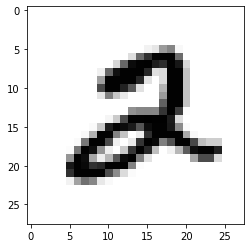

In [62]:
import matplotlib.pyplot as plt
digit = train_images[5].reshape(28, 28)
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

**"Fitting" the model**

In [63]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 4s 8ms/step - loss: 0.3599 - accuracy: 0.9028
Epoch 2/5
469/469 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.94 - 4s 8ms/step - loss: 0.1874 - accuracy: 0.9477
Epoch 3/5
469/469 [==============================] - 4s 8ms/step - loss: 0.1388 - accuracy: 0.9608
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.1103 - accuracy: 0.9695
Epoch 5/5
469/469 [==============================] - 3s 7ms/step - loss: 0.0909 - accuracy: 0.9751


**Using the model to make predictions**

In [64]:
test_digits = test_images[0:10]
predictions = model.predict(test_digits)
predictions[0]

array([2.8954324e-05, 1.0270638e-07, 2.8604842e-04, 1.2377123e-03,
       2.9007998e-07, 1.8394136e-05, 2.4240994e-09, 9.9835432e-01,
       2.0801923e-05, 5.3455686e-05], dtype=float32)

In [65]:
predictions[0].argmax()

7

In [66]:
predictions[0][7]

0.9983543

In [67]:
test_labels[0]

7

**Evaluating the model on new data**

In [68]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")

313/313 [==============================] - 2s 4ms/step - loss: 0.0967 - accuracy: 0.9722
test_acc: 0.9721999764442444


### Reimplementing our first example from scratch in TensorFlow

#### A simple Dense class

In [19]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

#### A simple Sequential class

In [20]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

In [21]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

#### A batch generator

In [22]:
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

### Running one training step

In [23]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

In [24]:
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(g * learning_rate)

In [25]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

### The full training loop

In [26]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")

In [27]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
loss at batch 0: 3.53
loss at batch 100: 2.26
loss at batch 200: 2.21
loss at batch 300: 2.10
loss at batch 400: 2.17
Epoch 1
loss at batch 0: 1.89
loss at batch 100: 1.89
loss at batch 200: 1.84
loss at batch 300: 1.71
loss at batch 400: 1.79
Epoch 2
loss at batch 0: 1.57
loss at batch 100: 1.59
loss at batch 200: 1.52
loss at batch 300: 1.43
loss at batch 400: 1.48
Epoch 3
loss at batch 0: 1.31
loss at batch 100: 1.35
loss at batch 200: 1.25
loss at batch 300: 1.21
loss at batch 400: 1.25
Epoch 4
loss at batch 0: 1.11
loss at batch 100: 1.16
loss at batch 200: 1.05
loss at batch 300: 1.05
loss at batch 400: 1.09
Epoch 5
loss at batch 0: 0.97
loss at batch 100: 1.02
loss at batch 200: 0.91
loss at batch 300: 0.93
loss at batch 400: 0.97
Epoch 6
loss at batch 0: 0.86
loss at batch 100: 0.92
loss at batch 200: 0.81
loss at batch 300: 0.84
loss at batch 400: 0.89
Epoch 7
loss at batch 0: 0.78
loss at batch 100: 0.83
loss at batch 200: 0.73
loss at batch 300: 0.77
loss at batch 40

### Evaluating the model

In [29]:
import numpy as np
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

accuracy: 0.82
